In [1]:
import cheetah
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [2]:
df = pd.read_csv(
    "../src/environments/electron_tt43.out", delim_whitespace=True, skiprows=45
)

# Shift column names to the left
df.columns = df.columns[1:].tolist() + [""]
# Remove first row
df = df.iloc[1:]
# Drop last column
df = df.iloc[:, :-1]
# Convert all columns except for NAME and KEYWORD to float
df[df.columns[2:]] = df[df.columns[2:]].astype(float)

df

,NAME,KEYWORD,S,L,SIGMA_X,SIGMA_Y,BETX,BETY,DX,DPX,...,DPY,ALFX,ALFY,X,Y,K1L,MUX,MUY,ENV_X,ENV_Y
1,TT43$START,MARKER,0.000000,0.000000,0.000982,0.000982,5.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,BEGI.1000,MARKER,0.000000,0.000000,0.000982,0.000982,5.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,DRIFT_0,DRIFT,0.179170,0.179170,0.000983,0.000983,5.006420,5.006420,0.000000,0.000000,...,0.000000,-0.035834,-0.035834,0.0,0.0,0.0,0.005701,0.005701,0.0,0.0
4,BPM.430028,MONITOR,0.179170,0.000000,0.000983,0.000983,5.006420,5.006420,0.000000,0.000000,...,0.000000,-0.035834,-0.035834,0.0,0.0,0.0,0.005701,0.005701,0.0,0.0
5,DRIFT_1,DRIFT,0.248570,0.069400,0.000984,0.000984,5.012357,5.012357,0.000000,0.000000,...,0.000000,-0.049714,-0.049714,0.0,0.0,0.0,0.007906,0.007906,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,IRIS2,INSTRUMENT,25.692571,0.000000,0.009802,0.010878,497.773560,494.605213,-0.005214,-0.000397,...,-0.056194,-44.983456,-43.909992,0.0,0.0,0.0,1.133650,2.080197,0.0,0.0
100,DRIFT_40,DRIFT,26.192571,0.500000,0.010245,0.011367,543.773800,539.490269,-0.005413,-0.000397,...,-0.056194,-47.017023,-45.860121,0.0,0.0,0.0,1.133803,2.080351,0.0,0.0
101,PLASMA.S,INSTRUMENT,26.192571,0.000000,0.010245,0.011367,543.773800,539.490269,-0.005413,-0.000397,...,-0.056194,-47.017023,-45.860121,0.0,0.0,0.0,1.133803,2.080351,0.0,0.0
102,DRIFT_41,DRIFT,30.000000,3.807429,0.013617,0.015086,960.761021,945.248720,-0.006923,-0.000397,...,-0.056194,-62.502344,-60.710072,0.0,0.0,0.0,1.134642,2.081200,0.0,0.0


In [3]:
df.columns


Index(['NAME', 'KEYWORD', 'S', 'L', 'SIGMA_X', 'SIGMA_Y', 'BETX', 'BETY', 'DX',
       'DPX', 'DY', 'DPY', 'ALFX', 'ALFY', 'X', 'Y', 'K1L', 'MUX', 'MUY',
       'ENV_X', 'ENV_Y'],
      dtype='object')

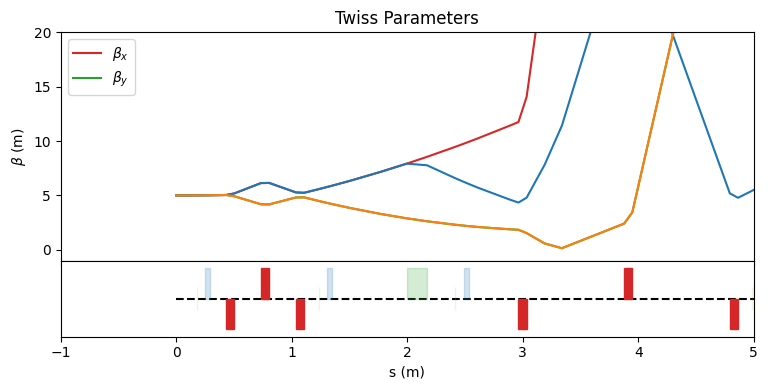

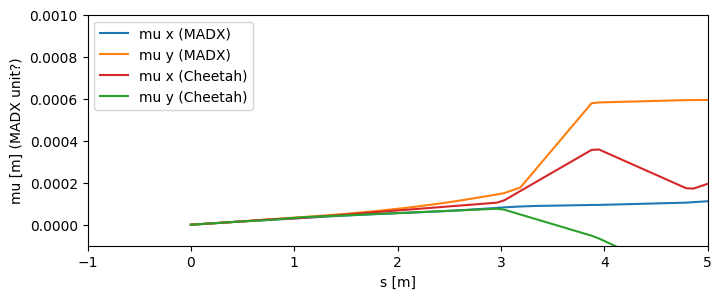

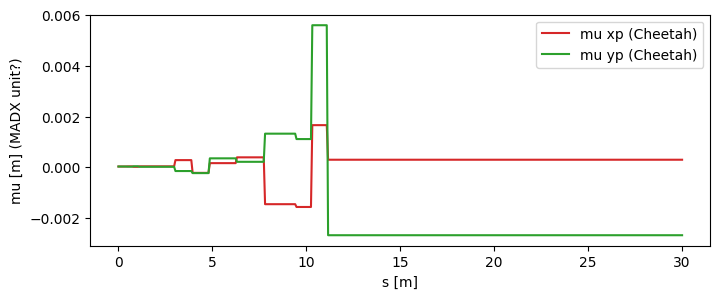

In [4]:
def convert_row_to_element(row) -> cheetah.Element:
    """Takes a row from the MADX output file and converts it into a Cheetah element."""
    sanitized_name = row.NAME.replace(".", "_").replace("$", "_")

    if row.KEYWORD == "MARKER":
        assert row.L == 0.0
        return cheetah.Marker(name=sanitized_name)
    elif row.KEYWORD == "DRIFT":
        return cheetah.Drift(name=sanitized_name, length=torch.as_tensor(row.L))
    elif row.KEYWORD == "MONITOR":
        assert row.L == 0.0
        assert sanitized_name.startswith("BPM")
        return cheetah.BPM(name=sanitized_name)
    elif row.KEYWORD == "KICKER":
        # TODO: Horizontal or vertical?
        return cheetah.HorizontalCorrector(
            name=sanitized_name, length=torch.as_tensor(row.L)
        )
    elif row.KEYWORD == "QUADRUPOLE":
        return cheetah.Quadrupole(
            name=sanitized_name,
            length=torch.as_tensor(row.L),
            # k1=torch.as_tensor(row.K1L),
            k1=torch.as_tensor(row.K1L / row.L),  # TODO: Correct?
        )
    elif row.KEYWORD == "INSTRUMENT":
        return cheetah.Drift(name=sanitized_name, length=torch.as_tensor(row.L))
    elif row.KEYWORD == "RBEND":
        return cheetah.RBend(name=sanitized_name, length=torch.as_tensor(row.L))
    else:
        raise NotImplementedError(f"Unknown element type: {row.KEYWORD}")


segment = cheetah.Segment(
    elements=[convert_row_to_element(row) for row in df.itertuples()]
)

# Fix missing angle for RBEND MBAWV_430100
segment.MBAWV_430100.angle = torch.as_tensor(0.0)


incoming_beam = cheetah.ParameterBeam.from_twiss(
    energy=torch.as_tensor(0.019006870) * 1e12,  # TODO: TeV -> eV ?
    beta_x=torch.as_tensor(df.loc[df.NAME == "TT43$START", "BETX"].values[0]),
    beta_y=torch.as_tensor(df.loc[df.NAME == "TT43$START", "BETY"].values[0]),
    alpha_x=torch.tensor(0.0),
    alpha_y=torch.tensor(0.0),
    emittance_x=torch.as_tensor(0.000000269),  # TODO: Unit?
    emittance_y=torch.as_tensor(0.000000269),  # TODO: Unit?
).transformed_to(
    mu_xp=torch.as_tensor(3.18173745604733e-05),
    mu_yp=torch.as_tensor(3.18173745604733e-05),
)

segment.plot_twiss_over_lattice(beam=incoming_beam)

plt.gcf().axes[0].plot(df["S"], df["BETX"], label="beta x")
plt.gcf().axes[0].plot(df["S"], df["BETY"], label="beta y")
plt.gcf().axes[0].set_ylim(-1, 20)
plt.gcf().axes[0].set_xlim(-1, 5)
plt.show()

longitudinal_beams = [incoming_beam]
s_positions = [0.0]
for element in segment.elements:
    if not hasattr(element, "length") or element.length == 0:
        continue

    outgoing = element.track(longitudinal_beams[-1])

    longitudinal_beams.append(outgoing)
    s_positions.append(s_positions[-1] + element.length)

plt.figure(figsize=(8, 3))
plt.plot(df["S"], df["MUX"] * 1e-3, label="mu x (MADX)")
plt.plot(df["S"], df["MUY"] * 1e-3, label="mu y (MADX)")
plt.plot(
    s_positions,
    [beam.mu_x for beam in longitudinal_beams],
    label="mu x (Cheetah)",
    c="tab:red",
)
plt.plot(
    s_positions,
    [beam.mu_y for beam in longitudinal_beams],
    label="mu y (Cheetah)",
    c="tab:green",
)
plt.xlabel("s [m]")
plt.ylabel("mu [m] (MADX unit?)")
plt.xlim(-1, 5)
plt.ylim(-0.1e-3, 1.0e-3)
plt.legend()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(
    s_positions,
    [beam.mu_xp for beam in longitudinal_beams],
    label="mu xp (Cheetah)",
    c="tab:red",
)
plt.plot(
    s_positions,
    [beam.mu_yp for beam in longitudinal_beams],
    label="mu yp (Cheetah)",
    c="tab:green",
)
plt.xlabel("s [m]")
plt.ylabel("mu [m] (MADX unit?)")
plt.legend()
plt.show()


In [5]:
df["S"].iloc[1:3]


2    0.00000
3    0.17917
Name: S, dtype: float64

In [6]:
df["MUX"].iloc[1:3]


2    0.000000
3    0.005701
Name: MUX, dtype: float64

In [7]:
(df["MUX"].iloc[2] - df["MUX"].iloc[1]) / (df["S"].iloc[2] - df["S"].iloc[1]) * 1e-3

3.18173745604733e-05

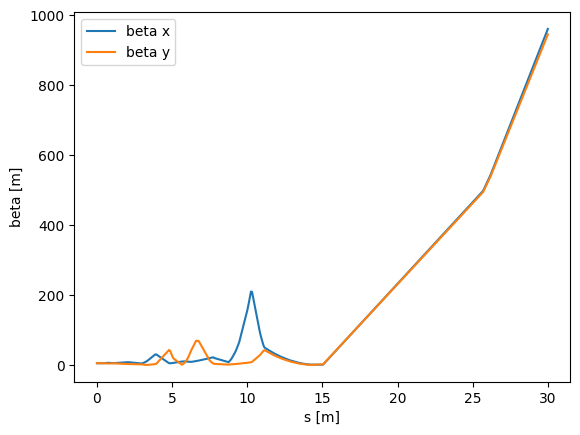

In [8]:
plt.plot(df["S"], df["BETX"], label="beta x")
plt.plot(df["S"], df["BETY"], label="beta y")
plt.legend()
plt.xlabel("s [m]")
plt.ylabel("beta [m]")
plt.show()

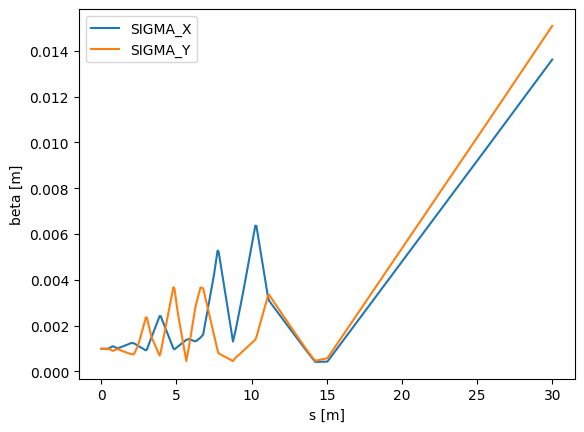

In [9]:
plt.plot(df["S"], df["SIGMA_X"], label="SIGMA_X")
plt.plot(df["S"], df["SIGMA_Y"], label="SIGMA_Y")
plt.legend()
plt.xlabel("s [m]")
plt.ylabel("beta [m]")
plt.show()

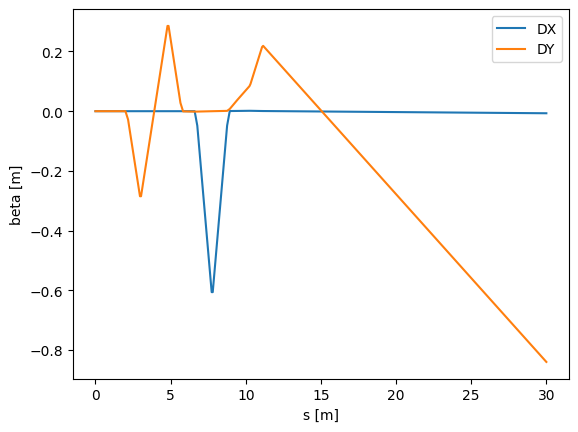

In [10]:
plt.plot(df["S"], df["DX"], label="DX")
plt.plot(df["S"], df["DY"], label="DY")
plt.legend()
plt.xlabel("s [m]")
plt.ylabel("beta [m]")
plt.show()

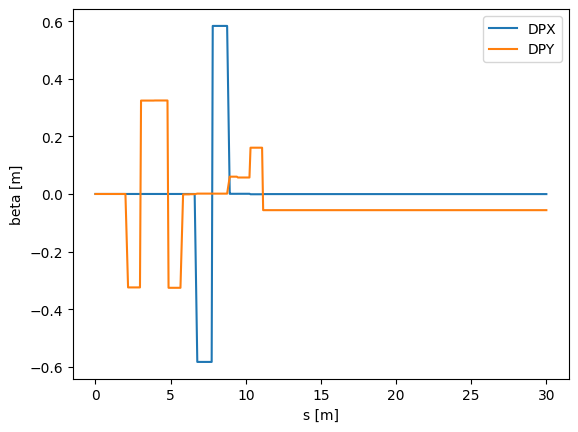

In [11]:
plt.plot(df["S"], df["DPX"], label="DPX")
plt.plot(df["S"], df["DPY"], label="DPY")
plt.legend()
plt.xlabel("s [m]")
plt.ylabel("beta [m]")
plt.show()

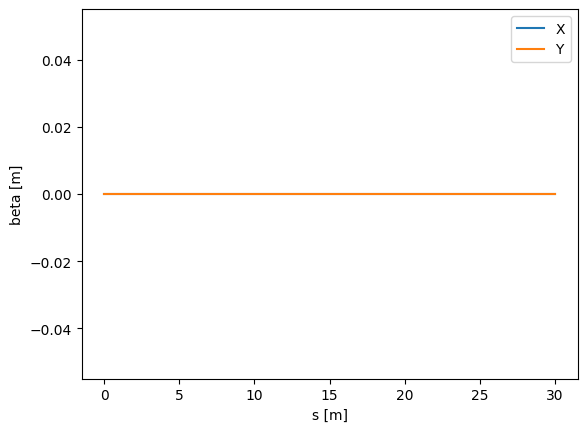

In [12]:
plt.plot(df["S"], df["X"], label="X")
plt.plot(df["S"], df["Y"], label="Y")
plt.legend()
plt.xlabel("s [m]")
plt.ylabel("beta [m]")
plt.show()

In [13]:
segment

Segment(elements=ModuleList(
  (0): Marker(name='TT43_START', device='cpu')
  (1): Marker(name='BEGI_1000', device='cpu')
  (2): Drift(length=tensor(0.1792), name='DRIFT_0', device='cpu')
  (3): BPM(name='BPM_430028', device='cpu')
  (4): Drift(length=tensor(0.0694), name='DRIFT_1', device='cpu')
  (5): HorizontalCorrector(length=tensor(0.0406), angle=tensor(0.), name='MCAWA_430029', device='cpu')
  (6): Drift(length=tensor(0.1410), name='DRIFT_2', device='cpu')
  (7): Quadrupole(length=tensor(0.0708), k1=tensor(-5.0858), misalignment=tensor([0., 0.]), tilt=tensor(0.), name='MQAWD_430031', device="'cpu'")
  (8): Drift(length=tensor(0.2317), name='DRIFT_3', device='cpu')
  (9): Quadrupole(length=tensor(0.0708), k1=tensor(9.5040), misalignment=tensor([0., 0.]), tilt=tensor(0.), name='MQAWF_430034', device="'cpu'")
  (10): Drift(length=tensor(0.2317), name='DRIFT_3', device='cpu')
  (11): Quadrupole(length=tensor(0.0708), k1=tensor(-8.2401), misalignment=tensor([0., 0.]), tilt=tensor(0.),

In [14]:
df[df["K1L"] > 0.0]

,NAME,KEYWORD,S,L,SIGMA_X,SIGMA_Y,BETX,BETY,DX,DPX,...,DPY,ALFX,ALFY,X,Y,K1L,MUX,MUY,ENV_X,ENV_Y
10,MQAWF.430034,QUADRUPOLE,0.803473,0.0708,0.001089,0.000897,6.146911,4.168955,0.000000,0.000000,...,0.000000,1.972158,-1.309646,0.0,0.0,0.672884,0.024240,0.026763,0.0,0.0
32,MQAWF.430118,QUADRUPOLE,3.948406,0.0708,0.002411,0.000821,30.114568,3.445027,-0.000000,0.000000,...,0.324518,20.894040,-10.254442,0.0,0.0,1.395009,0.094349,0.582312,0.0,0.0
56,MQAWF.430311,QUADRUPOLE,7.803610,0.0708,0.005231,0.000781,19.955098,3.161741,-0.606158,0.583355,...,0.001147,34.008555,4.909302,0.0,0.0,1.902521,0.153196,1.101540,0.0,0.0
72,MQAWF.412346,QUADRUPOLE,10.317508,0.0708,0.006350,0.001493,208.899680,8.777500,0.001339,-0.000963,...,0.160633,132.144124,-13.216334,0.0,0.0,1.187946,0.647070,1.589522,0.0,0.0


In [15]:
df[df["KEYWORD"] == "RBEND"]

,NAME,KEYWORD,S,L,SIGMA_X,SIGMA_Y,BETX,BETY,DX,DPX,...,DPY,ALFX,ALFY,X,Y,K1L,MUX,MUY,ENV_X,ENV_Y
20,MBAWV.430100,RBEND,2.170290,0.1755,0.001225,0.000746,7.771025,2.622943,-0.000000,-0.000000,...,-0.324380,2.548137,0.725805,0.0,0.0,0.0,0.058461,0.085570,0.0,0.0
40,MBAWV.430200,RBEND,5.831222,0.1755,0.001404,0.001079,10.207972,6.032640,-0.000000,0.000000,...,-0.001313,1.655288,-22.537536,0.0,0.0,0.0,0.128672,1.083898,0.0,0.0
50,MBAWH.430300,RBEND,6.776200,0.1755,0.001608,0.003625,12.617955,68.102237,-0.048460,-0.583006,...,0.001263,-4.221008,53.106859,0.0,0.0,0.0,0.143540,1.089661,0.0,0.0
58,MBAWH.412343,RBEND,8.935721,0.1755,0.001795,0.000602,16.694156,1.856662,0.000536,0.000582,...,0.060061,-30.891176,-1.410422,0.0,0.0,0.0,0.643409,1.533024,0.0,0.0


In [18]:
df[df["KEYWORD"] == "KICKER"]["NAME"]

6     MCAWA.430029
16    MCAWA.430040
24    MCAWA.430104
38    MCAWA.430130
46    MCAWA.430204
54    MCAWA.430309
64    MCAWA.412344
70    MCAWA.412345
76    MCAWA.412347
82    MCAWA.412349
90    MCAWA.412353
Name: NAME, dtype: object

In [19]:
df[df["KEYWORD"] == "MONITOR"]["NAME"]


4     BPM.430028
14    BPM.430039
22    BPM.430103
36    BPM.430129
44    BPM.430203
52    BPM.430308
62    BPM.412343
68    BPM.412345
74    BPM.412347
80    BPM.412349
86    BPM.412351
Name: NAME, dtype: object